<a href="https://colab.research.google.com/github/alirezash97/Cardio/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"alirezashafaei97","key":"9cb262aa0c5658ffc4eb45857c41903c"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d shayanfazeli/heartbeat -p /content
!unzip /content/heartbeat.zip -d /content/heartbeat

In [0]:
import pandas as pd
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Softmax, InputLayer, concatenate, Conv1D, Flatten, Dropout
from tensorflow.keras import backend as K
from random import uniform 
import random


from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix


In [0]:
train_df=pd.read_csv('/content/heartbeat/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/heartbeat/mitbih_test.csv',header=None)

In [5]:
train_df[187]=train_df[187].astype(int)
counter=train_df[187].value_counts()
print(counter)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


In [0]:
trainset = train_df.values
testset = test_df.values

In [0]:
def split(dataset, number_of_sample_per_category):
  
  new_dataset = np.zeros((np.sum(number_of_sample_per_category), dataset.shape[1]))
  pointer = 0
  
  for row in dataset :
    
    row_label = int(row[-1])
    
    if number_of_sample_per_category[row_label] > 0 :
      
      number_of_sample_per_category[row_label] -= 1
      new_dataset[pointer , :] = row
      pointer += 1

    else:

      pass
    
  
  return new_dataset




In [0]:
temp_trainset = split(trainset, [4000, 2223, 4000, 641, 4000])
temp_testset = split(testset, [500, 500, 500, 500, 500])

In [0]:
def data_augmentation(dataset, chance):
  
  augmented = 0
  number_of_rows = int(dataset.shape[0] + (dataset.shape[0] * (chance*2)))
  new_dataset = np.zeros((number_of_rows, dataset.shape[1]))
  pointer = 0 

  for row in dataset:
    
    rand_num = random.uniform(0, 1)
    if rand_num < chance:
      
      augmented += 1
      noise = np.random.normal(scale=0.01, size=187)
      new_signal = np.zeros((1, 188))
      new_signal[:, :187] = row[:187] + noise
      new_signal[:, -1:] = row[-1:] 
      new_dataset[pointer:pointer+1, :] = new_signal
      pointer += 1

    else :
      pass

    new_dataset[pointer, :] = row 
    pointer += 1

  return augmented, new_dataset  

  

In [0]:
augmented, trainset = data_augmentation(temp_trainset, 0.05)

In [0]:
filled = augmented + temp_trainset.shape[0]
trainset = trainset[:filled , :]

In [0]:
trainset = np.take(trainset,np.random.permutation(trainset.shape[0]),axis=0,out=trainset)
testset = np.take(testset,np.random.permutation(testset.shape[0]),axis=0,out=testset)

In [0]:
X_temp_train = trainset[:, :-1]
Y_train = trainset[:, -1:]
X_temp_test = testset[:, :-1]
Y_test = testset[:, -1:]

In [96]:
print("X_train : ", X_temp_train.shape)
print("Y_train : ", Y_train.shape)
print("X_test : ", X_temp_test.shape)
print("Y_test : ", Y_test.shape)

X_train :  (15603, 187)
Y_train :  (15603, 1)
X_test :  (21892, 187)
Y_test :  (21892, 1)


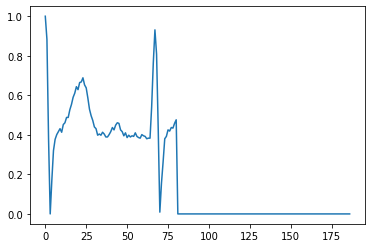

In [97]:
plt.plot(X_temp_train[7, :])
plt.show()

In [0]:

# One Hot enoding for target labels 
ohe = OneHotEncoder()
Y_train = ohe.fit_transform(Y_train.reshape(-1,1))
Y_test = ohe.transform(Y_test.reshape(-1,1))

# handle sparse matrix for keras 
Y_train = csr_matrix.toarray(Y_train)
Y_test = csr_matrix.toarray(Y_test)

In [99]:
print("X_train : ", X_temp_train.shape)
print("Y_train : ", Y_train.shape)
print("X_test : ", X_temp_test.shape)
print("Y_test : ", Y_test.shape)

X_train :  (15603, 187)
Y_train :  (15603, 5)
X_test :  (21892, 187)
Y_test :  (21892, 5)


In [67]:
Y_train[1000:1006, :]

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

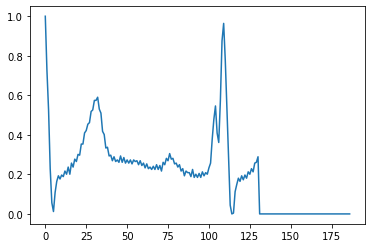

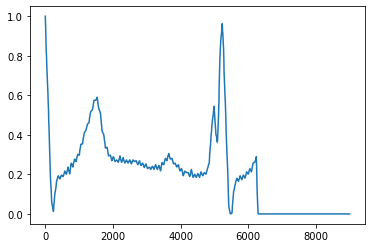

In [100]:

#### change X_train.shape from (1, 187) to (1, 9000) for transfer learning ####

X_train = np.zeros((X_temp_train.shape[0], 9000))
j = 48

for i, signal in enumerate(X_temp_train):

  for index, item in enumerate(signal):

    if index != 186:
      
      temp = np.random.uniform(signal[index], signal[index+1], 48)
      
      if (signal[index+1]) > (signal[index]) :
        temp = np.sort(temp)
      else:
        temp = -np.sort(-temp)


      X_train[i, index*j:(index+1)*(j)] = temp

    else: 
      pass


plt.plot(X_temp_train[1, :])
plt.show()
plt.plot(X_train[1, :])
plt.show()


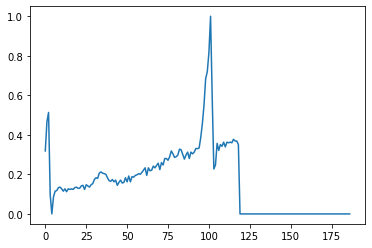

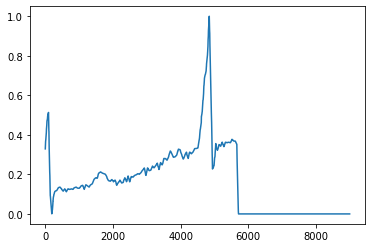

In [101]:

#### change X_test.shape from (1, 187) to (1, 9000) for transfer learning ####

X_test = np.zeros((X_temp_test.shape[0], 9000))
j = 48

for i, signal in enumerate(X_temp_test):

  for index, item in enumerate(signal):

    if index != 186:
      
      temp = np.random.uniform(signal[index], signal[index+1], 48)
      
      if (signal[index+1]) > (signal[index]) :
        temp = np.sort(temp)
      else:
        temp = -np.sort(-temp)


      X_test[i, index*j:(index+1)*(j)] = temp

    else: 
      pass


plt.plot(X_temp_test[1, :])
plt.show()
plt.plot(X_test[1, :])
plt.show()


In [102]:
X_train = X_train.reshape(15603, 9000, 1)
X_test = X_test.reshape(2500, 9000, 1)

ValueError: ignored

In [16]:
print("X_train : ", X_train.shape)
print("Y_train : ", Y_train.shape)
print("X_test : ", X_test.shape)
print("Y_test : ", Y_test.shape)

X_train :  (14864, 9000, 1)
Y_train :  (14864, 5)
X_test :  (2500, 9000, 1)
Y_test :  (2500, 5)


In [17]:
# load model
model = load_model('/content/drive/My Drive/Cardio/AF_Classification.h5')

# summarize model.
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 9000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 4498, 16)     96          input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_52 (Conv1D)              (None, 4498, 32)     4640        conv1d_51[0][0]                  
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 4498, 32)     128         conv1d_52[0][0]                  
____________________________________________________________________________________________

In [18]:
X_input = model.layers[-7].output
D0 = Dense(2048)(X_input)
Drop0 = Dropout(0.3)(D0)
Act0 = LeakyReLU()(Drop0)
D1 = Dense(512)(Act0)
Drop1 = Dropout(0.1)(D1)
Act1 = LeakyReLU()(Drop1)
D2 = Dense(5)(Act1)
Act2 = Softmax()(D2)

new_model = Model(inputs=model.inputs, outputs=Act2)
new_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 9000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 4498, 16)     96          input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_52 (Conv1D)              (None, 4498, 32)     4640        conv1d_51[0][0]                  
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 4498, 32)     128         conv1d_52[0][0]                  
______________________________________________________________________________________________

In [19]:
new_model.get_layer('conv1d_51').trainable = False
new_model.get_layer('conv1d_52').trainable = False
new_model.get_layer('conv1d_53').trainable = False
new_model.get_layer('conv1d_54').trainable = False
new_model.get_layer('conv1d_55').trainable = False
new_model.get_layer('conv1d_56').trainable = False
new_model.get_layer('conv1d_57').trainable = False
new_model.get_layer('conv1d_58').trainable = False
new_model.get_layer('conv1d_59').trainable = False
new_model.get_layer('conv1d_60').trainable = False
new_model.get_layer('conv1d_61').trainable = False
new_model.get_layer('conv1d_62').trainable = False
new_model.get_layer('conv1d_63').trainable = False
new_model.get_layer('conv1d_64').trainable = False
new_model.get_layer('conv1d_65').trainable = False
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 9000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 4498, 16)     96          input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_52 (Conv1D)              (None, 4498, 32)     4640        conv1d_51[0][0]                  
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 4498, 32)     128         conv1d_52[0][0]                  
______________________________________________________________________________________________

In [20]:
# compile model
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early Stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
new_model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_test, Y_test), callbacks=[es_callback])

Epoch 1/10
233/233 [==============================] - 2141s 9s/step - loss: 1.9472 - accuracy: 0.7129 - val_loss: 3.0862 - val_accuracy: 0.3560
Epoch 2/10
233/233 [==============================] - 2147s 9s/step - loss: 0.5613 - accuracy: 0.8124 - val_loss: 3.5946 - val_accuracy: 0.3796
Epoch 3/10
  6/233 [..............................] - ETA: 27:26 - loss: 0.5014 - accuracy: 0.8672

KeyboardInterrupt: ignored